In [2]:
# Setup
# This project requires Python 3.7 or above:

import sys

assert sys.version_info >= (3, 7)
# It also requires Scikit-Learn ≥ 1.0.1:

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
# Just like in the previous chapter, let's define the default font sizes to make the figures prettier:

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
  # And let's crate the images/classification folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MINST

In [3]:
# fetch MINST data set

# # from sklearn.datasets import fetch_openml

# mnist = fetch_openml(name="mnist_784", as_frame=False)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
# used different dataset with 10,000 less datapoints because openml was down.
# from collections import namedtuple
# from torchvision import datasets, transforms
# import numpy as np

# mnist = datasets.MNIST(".", download=True, transform=transforms.PILToTensor())
# X = np.stack([np.array(img) for img, _ in mnist]) / 255.0
# y = np.array([str(label) for _, label in mnist])
# X = X.reshape(-1, 28 * 28)
# MNIST = namedtuple("MNIST", ["data", "target", "DESCR", "keys"])
# mnist = MNIST(X, y, "Temporary hack", lambda: ("foo", "bar"))

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
X.shape

(70000, 784)

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [9]:
y.shape

(70000,)

(784,)


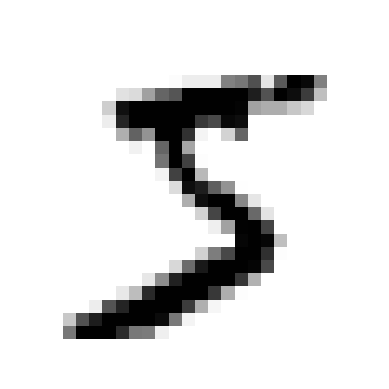

labeled 5


In [10]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap='binary')
  plt.axis('off')

some_digit = X[0]
print(some_digit.shape)
plot_digit(some_digit)
plt.show()
print(f'labeled {y[0]}')

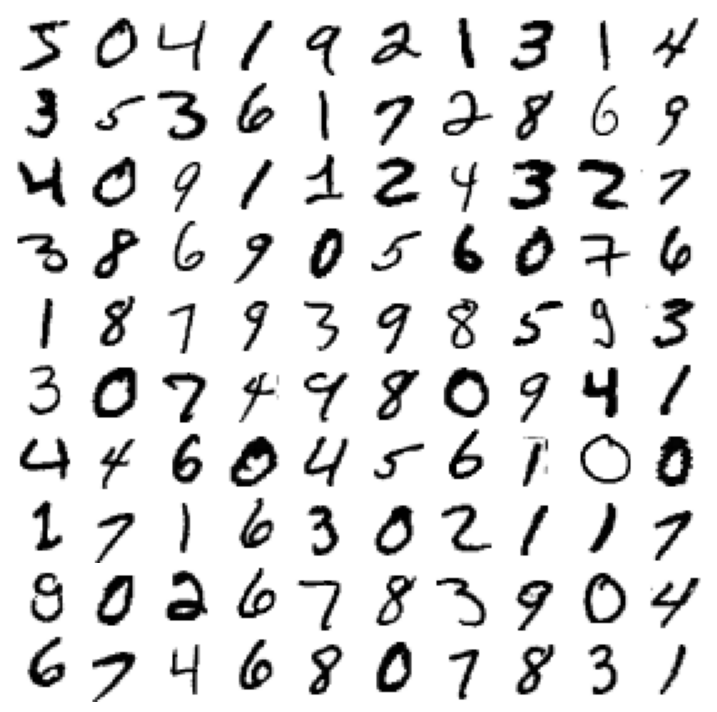

In [11]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
  plt.subplot(10, 10, idx + 1)
  plot_digit(image_data)

plt.subplots_adjust(wspace=0, hspace=0)
save_fig('more_digit_plot', tight_layout=False)
plt.show()

## Training a binary classifer

In [12]:
# open ml is down taking first 50,000 as traning last 10,000 as test
X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]

In [13]:
# produce mask
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
print(y_train_5)
print(y_test_5)

[ True False False ... False False False]
[False False False ... False  True False]


In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
# now that it is trained we are able to make predictions on it
sgd_clf.predict([some_digit])

array([ True])

In [16]:
# k-fold cross-validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.92452151, 0.96256075, 0.96219849])

In [17]:
# dummy classifier, classifies each image into most common class (e.g non-5)

from  sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # this means not 5 are detected

False


In [18]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')
''' only 10 percent of the images are 5, so if you guess every image is not 5
you will be right 90% of the time'''

' only 10 percent of the images are 5, so if you guess every image is not 5\nyou will be right 90% of the time'

In [19]:
# building cross_val_score to give more control to user
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True to shuffle dataset

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  x_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  x_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index];

  clone_clf.fit(x_train_folds, y_train_folds)
  y_pred = clone_clf.predict(x_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct/len(y_pred))

0.9245215095698086
0.9625607487850243
0.9621984879395176


## Confusion Matricess

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
y_train_pred # cross_val_predict is a function that generates cross-validated
# predictions for each data point of our dataset

array([ True, False, False, ..., False, False, False])

In [22]:
# confusion matrix just needs the predictions + target values
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[43915,  1579],
       [  933,  3573]])

## explanation of confsion matrix
- rows are the actual class (labels) here the first row is non-5 images and the second row is 5-images
- columns are the predicted class, here the first column are non-5 images predicted and second column is 5-images

- we can see that the model accuratley classified 44,756 images and misclassified 738 images for the non- 5 images. For the 5-images we see it misclassified 789 images and correclty classified 3717.


**A perfect classifer would have true positives and true negatives, so the confusion matrix will have non-zero values along its main diagonal**

In [23]:
# pretending we reach perfection

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[45494,     0],
       [    0,  4506]])

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3717 / (738 + 3717)

0.6935170807453416

In [25]:
recall_score(y_train_5, y_train_pred) # == 3717 / (789 + 3717)

0.7929427430093209

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7399047421826465

In [27]:
# scikit learn does not allow you to direclty set the threshold in SGD
# you can run the decision features and from there set up your threshold

y_scores = sgd_clf.decision_function([some_digit])

In [28]:
y_scores

array([3990.69284792])

In [29]:
threshold = 0


In [30]:
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

In [32]:
# raising the threshold
threshold = 300
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# this is great example of reducing recall when increasing the threshold
# we know that some_digit is 5, but increasing the threshold makes this a false negative
# thus decreasing recall. k

array([ True])

In [33]:
# return decision_functions instead of predicted values
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [34]:
# call precision_recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

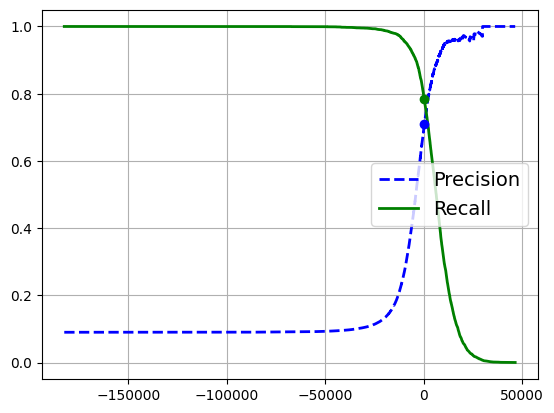

In [35]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
# plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
# d.axis([-50000, 50000, 0, 1])
plt.grid()
# plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

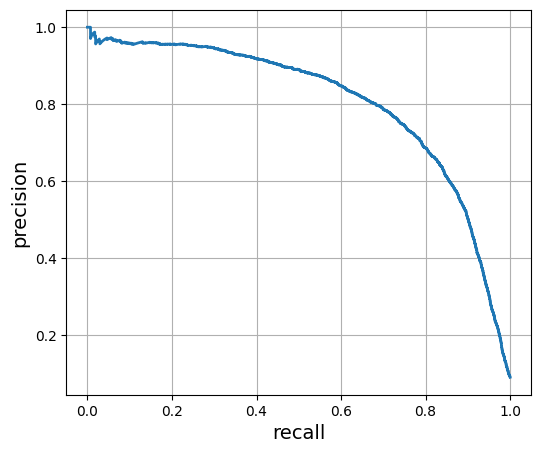

In [36]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()
plt.show()

In [37]:
# can search for idx for certain percision/recall with argmax
idx_for_90_percision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_percision]
threshold_for_90_precision

np.float64(7168.338578375478)

In [38]:
idx_for_90_recall = (recalls >= 0.90).argmax()
threshold_for_90_recall = recalls[idx_for_90_recall]
threshold_for_90_recall

np.float64(1.0)

In [39]:
# to make predictions do the following
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9002178649237472

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.45849977807367953

## ROC curve

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [43]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99441685, 0.99441685,
       1.        ])

In [44]:
tpr

array([0.00000000e+00, 2.21926320e-04, 7.32356858e-03, ...,
       9.99778074e-01, 1.00000000e+00, 1.00000000e+00])

In [45]:
thresholds

array([             inf,   46470.40005884,   29867.88457868, ...,
        -79280.71592247,  -79427.19799449, -182535.44348456])

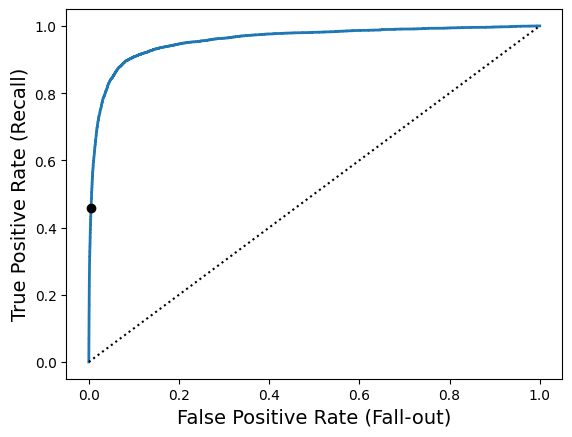

In [46]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='random classifiers ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='threshold for 90% precision')
plt.xlabel('False Positive Rate (Fall-out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

* again, we can see the trade-off in higher recall, has the recall increases so do the false-postives
* the dotted line shows a true random classifier
* way to measure the classifiers is to take the area under the curve, a perfect classifer will have area 1 and truly random classifer will have area 0.5

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.957975431165074)

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)


In [49]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [50]:
y_probas_forest[:2] # the probability of each row add up to 100%
# 1st row 85 probability its positive
# 2nd row 97 probability its negative

array([[0.15, 0.85],
       [0.97, 0.03]])

In [51]:
# 2nd column contains the estimated probs for the positive class
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

In [52]:
y_scores_forest

array([0.85, 0.03, 0.05, ..., 0.02, 0.01, 0.01])

In [53]:
thresholds_forest

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

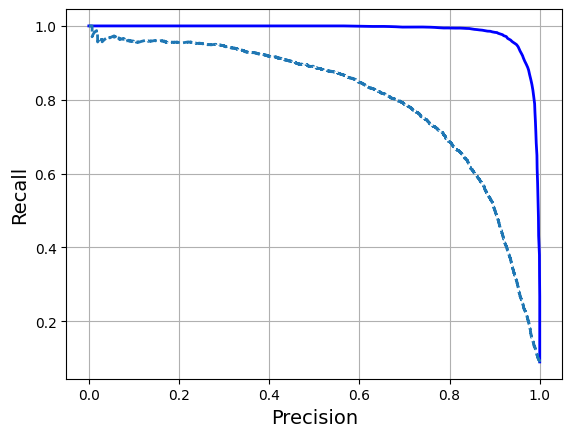

In [54]:
plt.plot(recalls_forest, precision_forest, 'b-', linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.show()

In [55]:
y_train_pred_forest = y_probas_forest[:, -1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)


0.9239503252513306

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983385160695164)

In [57]:
precision_score(y_train_5, y_train_pred_forest)

0.9891111673841478

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8668442077230359

## Multiclass classification

In [59]:
# when using binary classifier scikit learn autoamtically runs OvR or OvO
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [60]:
svm_clf.predict([some_digit]) # uses one vs one and made 45 precdictions from
# 45 classifiers trained

array(['5'], dtype=object)

In [61]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [62]:
class_id = some_digit_scores.argmax()

In [63]:
class_id

np.int64(5)

In [64]:
# when classifer is trained it stores the target values in the classes_

svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [65]:
svm_clf.classes_[class_id]

'5'

In [66]:
svm_clf.decision_function_shape = 'ovo'
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)
# scores for each of the 45 classifiers

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [67]:
# you can choose between OvO or OvR with calling the following
# OneVsOneClassifier
# OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [68]:
ovr_clf.predict([some_digit])


array(['5'], dtype='<U1')

In [69]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

In [70]:
len(ovr_clf.estimators_)

10

In [71]:
# can easily use SGDclassifier just as easily for multiclass classification

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array(['5'], dtype='<U1')

In [72]:
sgd_clf.decision_function([some_digit]).round()

array([[-18625., -37177., -15636.,  -3261., -17463.,    991., -33855.,
        -24042., -10952., -13384.]])

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86860263, 0.86950261, 0.87837514])

In [75]:
# the accuracy is good but you can do other things to improve accuracy
# like feature scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.90274195, 0.89758205, 0.90597624])

## Error Analysis

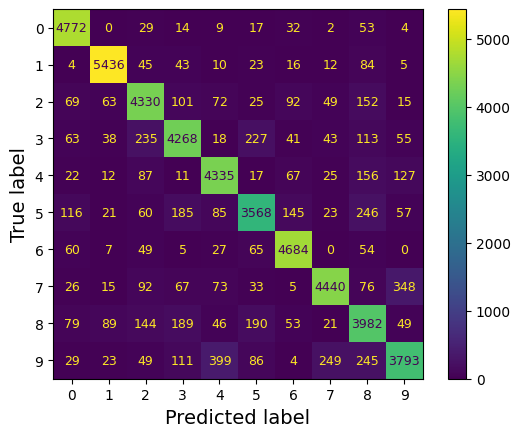

In [76]:
# review GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

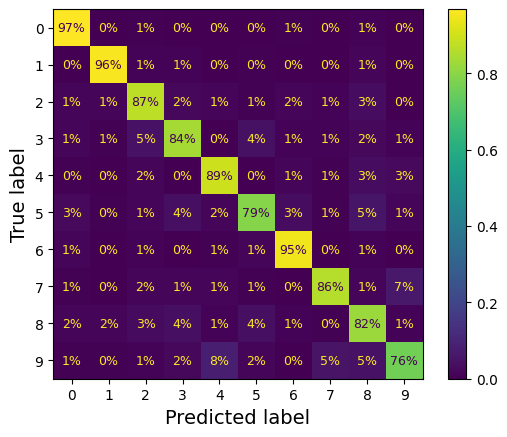

In [77]:
# as we can see 5 is slightly darker which could mean the model misclassified
# 5 a ton or there aren't that many 5s in the dataset, to make this uniform
# we can normalize all the rows with its sum
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize='true', values_format='.0%')
plt.show()

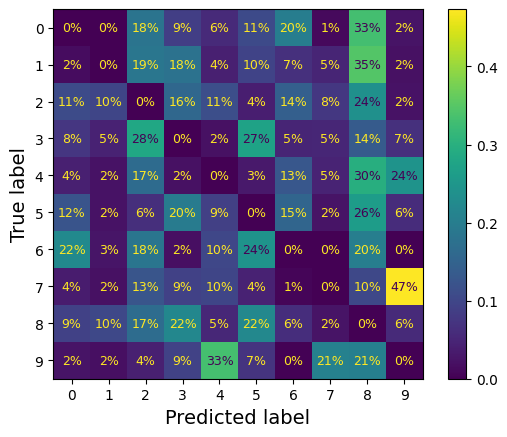

In [78]:
''' we can see that 5s have the lowest classification score with it most often
being misclassified to the labels of 3 and 8. We can slightly see that more
classes were misclassified as class 8. This doesn't directly jump out so we can
put zero weight on the correct predictions to get a better picture'''
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format='.0%')

In [79]:
''' as we can see above this gives us a better picture of what is the most common
misclassification and that is 8. But, it is important to note and keep in mind
we exluced the correct predictions and this is just percentages of the mislabeled
classes'''

' as we can see above this gives us a better picture of what is the most common\nmisclassification and that is 8. But, it is important to note and keep in mind\nwe exluced the correct predictions and this is just percentages of the mislabeled\nclasses'

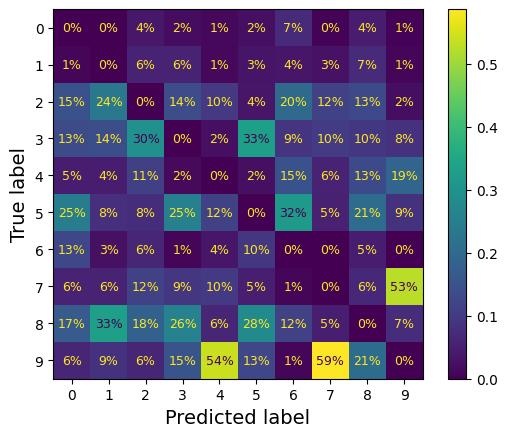

In [80]:
# can also normalize by column
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                       sample_weight=sample_weight,
                       normalize='pred', values_format='.0%')

In [81]:
# to improve the classifer, now you are able to target the reduction of the most
# misclassified item. As well, you are able to engineer new features maybe
# making the loops stand out more in order to improve performance

# You can also analyze individual errors
cl_a, cl_b = '3', '5'
x_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [82]:
x_aa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

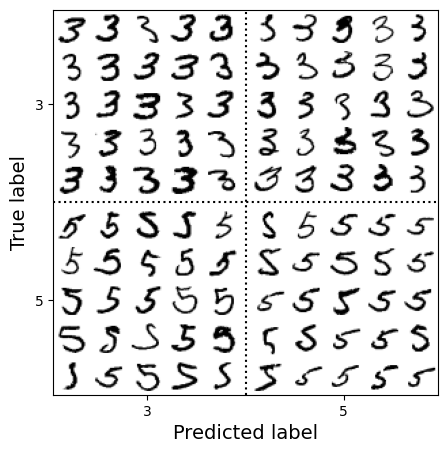

In [83]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(x_ba, (0, 0)), (x_bb, (1, 0)),
                                       (x_aa, (0, 1)), (x_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [84]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [85]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [ True, False],
       [False, False],
       [ True, False]])

In [86]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [87]:
# Note not all classifiers allow for multilabel classification KNeighbors does
knn_clf.predict([some_digit])

array([[False,  True]])

In [88]:
# to evaluate the classifier, one method is to use any of the binary classifiors
# metrics f1, recall, precision, compute it for one label and then average it out

y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_predict, average='macro')

0.9740900647874011

In [89]:
# this assumes each label holds the same weight and have around the same number of
# instances, to fix this set the average='weighted'
f1_score(y_multilabel, y_train_knn_predict, average='weighted')

0.9756568987244143

In [90]:
# to use models that don't support mutlilabel classification we can use a
# classifier chain that allows you to chain outputs into inputs of another
# classifier

from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [91]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

In [92]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
x_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [93]:
y_train_mod = X_train
y_test_mod = X_test

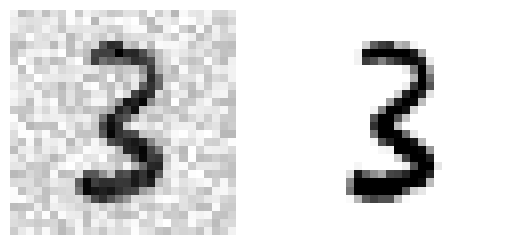

In [94]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

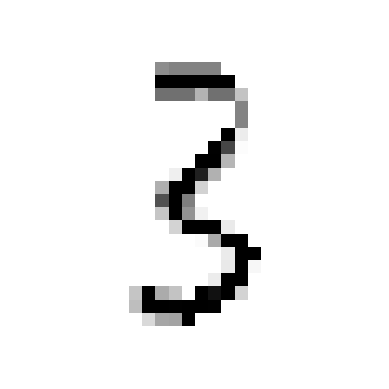

In [96]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()